# 1. Import the required libraries

In [21]:
# # Standard code libraries
import os
import platform
import glob
import numpy as np
import pandas as pd
import statistics
import math
from scipy import signal
from scipy.signal import butter, lfilter
from resurfemg.preprocessing import envelope as evl
from resurfemg.preprocessing import airwaypressure as paw
from resurfemg.postprocessing import event_detection as ed
from resurfemg.pipelines import pipeline_SEISMIC as ps
import matplotlib.pyplot as plt
import scipy.stats as stats 

# Custom code libraries from ReSurfEMG
#repo_path = 'C:\SEISMIC_study\ReSurfEMG'
#sys.path.append(repo_path)

from resurfemg.config.config import Config
from resurfemg.data_classes.data_classes_SEISMIC import (
VentilatorDataGroup, EmgDataGroup, TimeSeries)
from resurfemg.preprocessing.ecg_removal import *


%matplotlib widget

ModuleNotFoundError: No module named 'pipeline_SEISMIC_copy'

## 2. Load the ventilator and sEMG data

In [4]:
# Identify all recordings available for the selected patient/measurement_date

# Root directory for test data
config = Config()
root_patient_data_directory = \
    config.get_directory('root_emg_directory')

if platform.system() == 'Windows':
    path_sep = "\\"
else:
    path_sep = '/'

emg_pattern = os.path.join(root_patient_data_directory, '**/*.npy')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []

for file in emg_and_vent_files:
    if 'paw' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)

emg_file_chosen = emg_files[7]
vent_file_chosen = vent_files[7]
print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

The chosen files are:
 E:\Data_CSV_renamed_voor_resurf\two_track_emg_Rotterdam_SEISMIC-002_t24.npy 
 E:\Data_CSV_renamed_voor_resurf\paw_Rotterdam_SEISMIC-002_t24.npy


In [5]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg_samples = np.load(emg_file_chosen)
fs_emg = 2048
data_vent_samples = np.load(vent_file_chosen)
fs_vent = 100

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
y_vent = data_vent_samples

In [6]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['Costmar', 'Intercost'],
    units=2*['uV'],
    remove_length=5
    )

# Data is stored in:
# fs        --> emg_timeseries.fs
# labels    --> emg_timeseries.labels
# units     --> emg_timeseries.units
# ECG       --> emg_timeseries.channels[0] = TimeSeries object
# EMGdi     --> emg_timeseries.channels[1: TimeSeries object
# peaks     --> emg_timeseries.peaks
# remove_length --> amount of seconds you want to remove from the beginning and end
#   with:
#   emg_timeseries.channels[0].fs = fs
#   emg_timeseries.channels[0].y_raw = y_emg[0, :]
#   emg_timeseries.channels[0].t_data = time axis data for y_raw
#   emg_timeseries.channels[0].y_clean = None
#   emg_timeseries.channels[0].y_baseline = None
#   emg_timeseries.channels[0].y_baseline = None
#   etc.
# From the labels 'ECG' is automatically detected.

# Define the time axes
t_emg = [i/fs_emg for i in range(len(emg_timeseries.channels[0].y_raw))]

In [7]:
# Store the ventilator data in a group of TimeSeries objects
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=fs_vent,
    labels=['Paw'],
    units=['cmH2O'],
    remove_length = 5)

# Data is stored in:
# fs        --> vent_timeseries.fs
# labels    --> vent_timeseries.labels
# units     --> vent_timeseries.units
# ECG       --> vent_timeseries.channels[0: TimeSeries object
# EMGdi     --> vent_timeseries.channels[1] = TimeSeries object
#   with:
#   vent_timeseries.channels[0].fs = fs
#   vent_timeseries.channels[0].y_raw = y_vent[0, :]
#   vent_timeseries.channels[0].t_data = time axis data for y_raw
#   vent_timeseries.channels[0].y_clean = None
#   vent_timeseries.channels[0].y_baseline = None
#   vent_timeseries.channels[0].y_baseline = None
#   etc.
# From the labels 'P_aw', 'F', and 'Vvent' are automatically detected.

# Define the time axes
t_vent = [i/fs_vent for i in range(len(vent_timeseries.channels[0].y_raw))]

Auto-detected Paw channel from labels.


# 3. Pre-process the data

In [8]:
# Filter
emg_timeseries.filter(hp_cf=30)
# Which equals:
# emg_timeseries.filter(
#     signal_type='raw',
#     hp_cf=20.0,
#     lp_cf=500.0,    
#     channel_idxs=[0, 1],
# )
# Where:
# signal_type:      Filter the raw, just assigned, data
# hp_cf:            High-pass cut-off frequency of 20 Hz
# lp_cf:            Low-pass cut-off frequency of 500 Hz
# channel_idxs:     For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean

clean_after_hp0 = emg_timeseries.channels[0].y_clean
clean_after_hp1 = emg_timeseries.channels[1].y_clean


In [10]:
emg_timeseries.remove_outliers()
# Which equals:
# emg_timeseries.remove_outliers(
#     signal_type='clean',  
#     channel_idxs=[0, 1],
#     lowest_threshold=None
# )
# Where:
# signal_type:      Filter the clean, just filtered, data
# channel_idxs:     For all channels (None would default to this)
# lowest_threshold: Default is 20 uV

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean

removed_outliers = emg_timeseries.channels[1].y_clean

In [12]:
# Gate the EMG
emg_timeseries.gating(remove_outliers=True, gate_width_samples = fs_emg//7)
# Which equals:
# emg_timeseries.gating(
#     signal_type='clean',        
#     gate_width_samples=None,    
#     ecg_peak_idxs=None,         
#     ecg_raw=None,               
#     bp_filter=True,
#     channel_idxs=None,
#     remove_outliers = None
# )
# Where:
# signal_type:          Filter the clean, just filtered, data
# gate_width_samples:   Gate width, `None` defaults to fs // 10
# ecg_peak_idxs:        Sample idxs of ECG peaks, when `None` peaks are 
#                       automatically identified.
# ecg_raw:              ECG data to detect ECG peaks in if no ecg_peak_idxs are
#                       provided. If `None` and no ecg-channel is detected
#                       from the labels the raw channel data is used.
# bp_filter:            True/False: Filter the provided ecg_raw between 1-500
#                       Hz before peak detection
# channel_idxs:         For all channels (None would default to this)
# remove_outliers:      True if outliers are present in the raw data. None is default.

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean

gated = emg_timeseries.channels[1].y_clean

In [14]:
# Calculate the envelope of the signal
emg_timeseries.envelope()
# Which equals:
# emg_timeseries.envelope(
#     env_window=None,
#     env_type='rms',
#     signal_type='clean',
# )
# Where:
# env_window:           Envelope window width, `None` defaults to fs // 5
# env_type:             'rms' for root-mean-square (default), 'arv' for average
#                       rectified
# signal_type:          Calculate the envelope over the clean data

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_env

In [16]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.baseline()
# Which equals:
# emg_timeseries.baseline(
#     percentile=33,
#     window_s=int(7.5 * fs_emg),
#     step_s=fs_emg // 5,
#     method='default',
#     signal_type='env',
#     augm_percentile=25,
#     ma_window=None,
#     perc_window=None,
#     channel_idxs=[0, 1], 
# )
# Where:
# percentile:       Percentile of signal in the window to take as the baseline
#                   value 
# window_s:         Window length in samples (default: int(7.5 * fs))
# step_s:           Number of consecutive samples with the same baseline value
#                   (default: fs // 5)
# method:           'default' or 'slopesum'
# signal_type:      Calculate the baseline over the envelope (y_env) for emg 
#                   and over the original signal for p_vent
# augm_percentile   Augmented_percentile for slopesum baseline
# ma_window:        Moving average window in samples for average dy/dt in
#                   slopesum baseline
# perc_window:      'perc_window' for slopesum baseline.
# channel_idxs:     For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_baseline

# 4. Quality assesment of preprocessed signal

In [17]:
# Check the quality of the preprocessed data
emg_timeseries.quality_check()
# Which equals:
# emg_timeseries.baseline(
#     percentile=33,
#     window_s=int(7.5 * fs_emg),
#     step_s=fs_emg // 5,
#     method='default',
#     signal_type='env',
#     augm_percentile=25,
#     ma_window=None,
#     perc_window=None,
#     channel_idxs=[0, 1], 
# )
# Where:
# percentile:       Percentile of signal in the window to take as the baseline
#                   value 
# window_s:         Window length in samples (default: int(7.5 * fs))
# step_s:           Number of consecutive samples with the same baseline value
#                   (default: fs // 5)
# method:           'default' or 'slopesum'
# signal_type:      Calculate the baseline over the envelope (y_env) for emg 
#                   and over the original signal for p_vent
# augm_percentile   Augmented_percentile for slopesum baseline
# ma_window:        Moving average window in samples for average dy/dt in
#                   slopesum baseline
# perc_window:      'perc_window' for slopesum baseline.
# channel_idxs:     For all channels (None would default to this)

In [18]:
# Creates a dataframe containing all the quality outcomes

emg_timeseries.quantify_outcomes()
# Which equals:
# emg_timeseries.emg_timeseries(
#     channel_idxs=None)
#
# Where:
# channel_idxs:     For all channels (None would default to this)

5. Process airway pressure

In [19]:
vent_timeseries.pipeline_process_vent()
# This analyses the airway pressure data and finds different moments.
# See all the steps in the file 'airwaypressure.py' which is called on in 'data_classes_SEISMIC.py'
# 
#  Data is stored in:
#   time at which the MV ends to support --> vent_timeseries.time_end_in_mv
#   value of the time at which the MV ends to support --> vent_timeseries.peak_end_in_mv
#   index at which the MV ends to support --> vent_timeseries.idx_end_in_mv
#   time at which the MV starts to support --> vent_timeseries.time_start_in_mv
#   value of the time at which the MV starts to support --> vent_timeseries.peak_start_in_mv 
#   index at which the MV starts to support --> vent_timeseries.indx_start_in_mv 
#   time at which the patient starts to inhale -->  vent_timeseries.time_bt
#   value of the time at which the patient starts to inhale -->  vent_timeseries.bt 
#   index  at which the patient starts to inhale -->  vent_timeseries.idx_bt
#   etc.

1
2
3
4


6. Split valid and invalid peaks

In [22]:
# Use found peaks and peak assesment to split the true and false peaks    
peak_idxs = emg_timeseries.channels[0].peaks['breaths'].peak_df.iloc[:,0]
peak_idxs, peak_start_idxs, peak_end_idxs, __, __, __ = ed.onoffpeak_baseline_crossing(
    emg_timeseries.channels[0].y_env,emg_timeseries.channels[0].y_baseline, peak_idxs)
peak_parameters = [peak_idxs, peak_start_idxs, peak_end_idxs]
dict_peak_parameters_emg0 = ps.take_valid_peaks(emg_timeseries.channels[0].y_env, peak_parameters, emg_timeseries.channels[0].df_quality_outcomes, fs_emg)

peak_idxs = emg_timeseries.channels[1].peaks['breaths'].peak_df.iloc[:,0]
peak_idxs, peak_start_idxs, peak_end_idxs, __, __, __ = ed.onoffpeak_baseline_crossing(
    emg_timeseries.channels[1].y_env,emg_timeseries.channels[1].y_baseline, peak_idxs)
peak_parameters = [peak_idxs, peak_start_idxs, peak_end_idxs]
dict_peak_parameters_emg1 = ps.take_valid_peaks(emg_timeseries.channels[1].y_env, peak_parameters, emg_timeseries.channels[1].df_quality_outcomes, fs_emg)


7. Detect asynchronies

In [24]:
# Detect auto-trigger from airway pressure
time_auto_trigger_vent, val_auto_trigger_vent = ps.detect_auto_trigger(
    vent_timeseries.channels[0].y_raw, vent_timeseries.time_start_in_mv, vent_timeseries.time_bt, None, fs_vent) 

# Detect auto-trigger from sEMG
time_auto_trigger_emg0, val_auto_trigger_emg0 = ps.detect_auto_trigger(
    emg_timeseries.channels[0].y_env, vent_timeseries.time_start_in_mv, dict_peak_parameters_emg0['peak_start']['valid']['time'], 
    dict_peak_parameters_emg0['peak_top']['invalid']['idx'], fs_emg, emg=True)
time_auto_trigger_emg1, val_auto_trigger_emg1 = ps.detect_auto_trigger(
    emg_timeseries.channels[1].y_env, vent_timeseries.time_start_in_mv, dict_peak_parameters_emg1['peak_start']['valid']['time'], 
    dict_peak_parameters_emg1['peak_top']['invalid']['idx'], fs_emg, emg=True)

In [27]:
# Detect wasted effort
time_wasted_effort_emg0, val_wasted_effort_emg0 = ps.detect_wasted_effort(
    emg_timeseries.channels[0].y_env, dict_peak_parameters_emg0['peak_start']['valid']['time'], vent_timeseries.time_end_in_mv, fs_emg)
time_wasted_effort_emg1, val_wasted_effort_emg1 = ps.detect_wasted_effort(
    emg_timeseries.channels[1].y_env, dict_peak_parameters_emg1['peak_start']['valid']['time'], vent_timeseries.time_end_in_mv, fs_emg)

8. Compare asynchrony data

In [29]:
df_wasted_effort =ps.match_events('wasted effort','diaphragm sEMG', time_wasted_effort_emg0, 'intercostal sEMG', time_wasted_effort_emg1)
df_auto_trigger_emgs = ps.match_events('auto-trigger', 'diaphragm sEMG', time_auto_trigger_emg0, 'intercostal sEMG', time_auto_trigger_emg1)
dict_auto_trigger, df_auto_trigger = ps.match_3_signals_auto_trigger(df_auto_trigger_emgs, time_auto_trigger_vent,fs_emg, fs_vent, emg_timeseries.channels[0].y_env, 
                                emg_timeseries.channels[1].y_env, vent_timeseries.channels[0].y_raw)

wasted effort between diaphragm sEMG and intercostal sEMG compared:
Number of wasted effort on only one signal:  9 out of 11
Of which 5 only on diaphragm sEMG
and 4 only on intercostal sEMG 

auto-trigger between diaphragm sEMG and intercostal sEMG compared:
Number of auto-trigger on only one signal:  54 out of 69
Of which 30 only on diaphragm sEMG
and 24 only on intercostal sEMG 

Auto-trigger between EMGs and the airwaypressure compared:
Number of auto-triggers on not all signals:  69 out of 69
Of which 30 only on the diaphragm EMG
Of which 24 only on the intercostal EMG
Of which 0 only on the ventilator
Of which 15 only on both the EMGs


VISUALIZATION

MORE INFORMATION
Measuring time: 1827618
Number of measured breathes by diaphragm sEMG: 207
Number of measured breathes by intercostal sEMG: 109
Number of measured breathes by airway pressure: 266


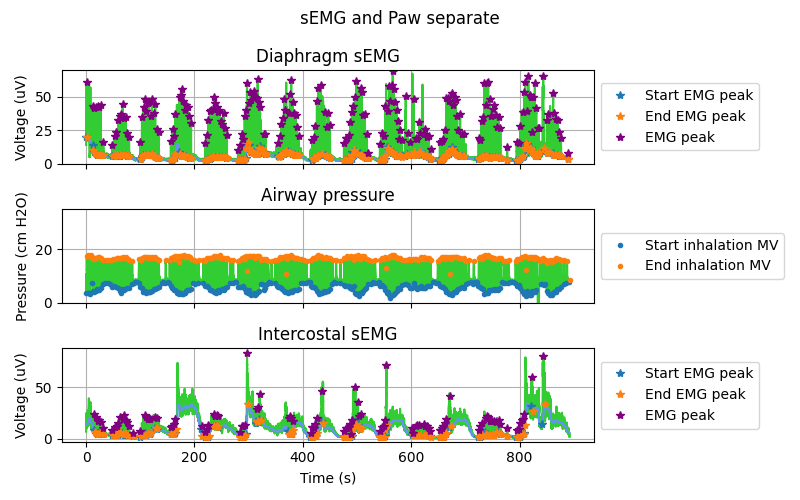

In [30]:
# Detected moments (begin breathing etc.)

fig, axs = plt.subplots(3,sharex=True, figsize=(8,5))
fig.suptitle('sEMG and Paw separate')

axs[0].set_title("Diaphragm sEMG")
axs[0].plot(t_emg,emg_timeseries.channels[0].y_env, color='limegreen')
axs[0].plot(t_emg, emg_timeseries.channels[0].y_baseline, color='cornflowerblue')
axs[0].plot(dict_peak_parameters_emg0['peak_start']['valid']['time'],dict_peak_parameters_emg0['peak_start']['valid']['value'],'*',label='Start EMG peak')
axs[0].plot(dict_peak_parameters_emg0['peak_end']['valid']['time'],dict_peak_parameters_emg0['peak_end']['valid']['value'],'*',label='End EMG peak')
axs[0].plot(dict_peak_parameters_emg0['peak_top']['valid']['time'],dict_peak_parameters_emg0['peak_top']['valid']['value'],'*',label='EMG peak', color='purple')
axs[0].set_ylim([0, 70])
axs[0].grid()
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_ylabel("Voltage (uV)") 


axs[1].set_title("Airway pressure")
axs[1].plot(t_vent, vent_timeseries.channels[0].y_raw, color='limegreen')
axs[1].plot(vent_timeseries.time_start_in_mv,vent_timeseries.peak_start_in_mv,'.',label='Start inhalation MV')
axs[1].plot(vent_timeseries.time_end_in_mv,vent_timeseries.peak_end_in_mv,'.', label='End inhalation MV')
axs[1].grid()
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].set_ylim([0, 35])
axs[1].set_ylabel("Pressure (cm H2O)") 

axs[2].set_title("Intercostal sEMG")
axs[2].plot(t_emg,emg_timeseries.channels[1].y_env, color='limegreen')
axs[2].plot(t_emg,emg_timeseries.channels[1].y_baseline, color='cornflowerblue')
axs[2].plot(dict_peak_parameters_emg1['peak_start']['valid']['time'],dict_peak_parameters_emg1['peak_start']['valid']['value'],'*',label='Start EMG peak')
axs[2].plot(dict_peak_parameters_emg1['peak_end']['valid']['time'],dict_peak_parameters_emg1['peak_end']['valid']['value'],'*',label='End EMG peak')
axs[2].plot(dict_peak_parameters_emg1['peak_top']['valid']['time'],dict_peak_parameters_emg1['peak_top']['valid']['value'],'*',label='EMG peak', color='purple')
#axs[2].set_xlim([379, 383])
axs[2].grid()
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].set_ylabel("Voltage (uV)") 
axs[2].set_xlabel("Time (s)") 

plt.tight_layout(rect=[0, 0, 0.999, 1])

print('MORE INFORMATION')
print('Measuring time:', len(t_emg))
print('Number of measured breathes by diaphragm sEMG:', len(dict_peak_parameters_emg0['peak_top']['valid']['time']))
print('Number of measured breathes by intercostal sEMG:', len(dict_peak_parameters_emg1['peak_top']['valid']['time']))
print('Number of measured breathes by airway pressure:', len(vent_timeseries.time_end_in_mv))


C:\Users\cmelb\AppData\Local\Temp\ipykernel_32852\236369687.py:51: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(pad=5.0)  # Creates space for titles and labels


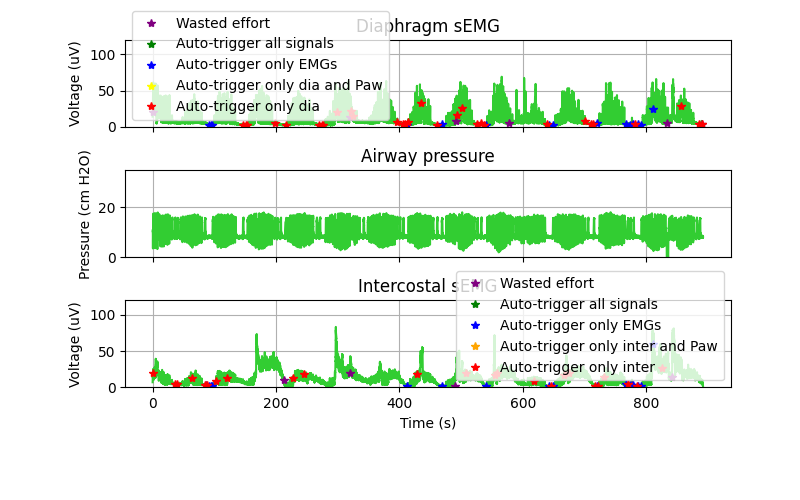

In [32]:
# Detection asynchronies

fig, axs = plt.subplots(3, sharex=True, figsize=(8,5))
#fig.suptitle('detected events')

axs[0].set_title("Diaphragm sEMG")
axs[0].plot(t_emg,emg_timeseries.channels[0].y_env,color='limegreen')
axs[0].plot(time_wasted_effort_emg0,val_wasted_effort_emg0,'*',label='Wasted effort', color='purple')
axs[0].set_ylabel("Voltage (uV)") 
axs[0].plot(dict_auto_trigger['diaphragm']['times'][0],dict_auto_trigger['diaphragm']['values'][0],'*',label='Auto-trigger all signals', color='green')
axs[0].plot(dict_auto_trigger['diaphragm']['times'][1],dict_auto_trigger['diaphragm']['values'][1],'*',label='Auto-trigger only EMGs', color='blue')
axs[0].plot(dict_auto_trigger['diaphragm']['times'][2],dict_auto_trigger['diaphragm']['values'][2],'*',label='Auto-trigger only dia and Paw', color='yellow')
axs[0].plot(dict_auto_trigger['diaphragm']['times'][3],dict_auto_trigger['diaphragm']['values'][3],'*',label='Auto-trigger only dia', color='red')
axs[0].set_ylim([0, 120])
axs[0].grid()
axs[0].legend()
#axs[0].set_xlim([414, 419.5])

#axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[1].set_title("Airway pressure")
axs[1].plot(t_vent, vent_timeseries.channels[0].y_raw, color='limegreen')
#axs[1].plot(time_auto_trigger_vent, val_auto_trigger_vent, '*', label='auto-trigger vent')
axs[1].set_ylabel("Pressure (cm H2O)") 

axs[1].plot(dict_auto_trigger['airway pressure']['times'][0],dict_auto_trigger['airway pressure']['values'][0],'*',label='Auto-trigger all signals', color='green')
axs[1].plot(dict_auto_trigger['airway pressure']['times'][1],dict_auto_trigger['airway pressure']['values'][1],'*',label='Auto-trigger only dia and Paw', color='yellow')
axs[1].plot(dict_auto_trigger['airway pressure']['times'][2],dict_auto_trigger['airway pressure']['values'][2],'*',label='Auto-trigger only inter and Paw', color='orange')
axs[1].plot(dict_auto_trigger['airway pressure']['times'][3],dict_auto_trigger['airway pressure']['values'][3],'*',label='Auto-trigger only Paw', color='red')
axs[1].grid()
#axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].set_ylim([0, 35])
#axs[1].set_xlim([414, 419.5])


axs[2].set_title("Intercostal sEMG")
axs[2].plot(t_emg,emg_timeseries.channels[1].y_env, color='limegreen')
axs[2].plot(time_wasted_effort_emg1,val_wasted_effort_emg1,'*',label='Wasted effort', color='purple')
axs[2].plot(dict_auto_trigger['intercostal']['times'][0],dict_auto_trigger['intercostal']['values'][0],'*',label='Auto-trigger all signals', color='green')
axs[2].plot(dict_auto_trigger['intercostal']['times'][1],dict_auto_trigger['intercostal']['values'][1],'*',label='Auto-trigger only EMGs', color='blue')
axs[2].plot(dict_auto_trigger['intercostal']['times'][2],dict_auto_trigger['intercostal']['values'][2],'*',label='Auto-trigger only inter and Paw', color='orange')
axs[2].plot(dict_auto_trigger['intercostal']['times'][3],dict_auto_trigger['intercostal']['values'][3],'*',label='Auto-trigger only inter', color='red')
axs[2].set_ylim([0, 120])
#axs[2].set_xlim([565, 585])
axs[2].grid()
axs[2].legend()
#axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].set_ylabel("Voltage (uV)") 
axs[2].set_xlabel("Time (s)") 

plt.tight_layout(pad=5.0)  # Creates space for titles and labels
plt.subplots_adjust(top=0.92, hspace=0.5)  # Add more space at the top for the main title and adjust hspace



